In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import random

%matplotlib inline
%load_ext autoreload
%autoreload 2

from vae.models.vae import VAE
from vae.trainers.trainer import ModelTrainer


In [2]:
torch.manual_seed(1)

bs= 128

def random_binarize(img):
    return (torch.rand_like(img) < img).type(torch.float)

transforms_stack = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(random_binarize),
])

train = datasets.MNIST(root='../data/',
                       train=True,
                       transform=transforms_stack,
                       download=False)

test = datasets.MNIST(root='../data/',
                    train=False,
                    transform=transforms_stack,
                    download=False) 




# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=bs, shuffle=False)

In [3]:
vae = VAE()
if torch.cuda.is_available():
    vae.cuda()

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader.dataset.data.shape[0]

trainer = ModelTrainer(vae, train_loader, test_loader, n_epochs=30)
trainer.train()

Train Epoch: 0 [0/60000 (0%)]	Loss: 46232.957031
Train Epoch: 0 [12800/60000 (21%)]	Loss: 46405.281250
Train Epoch: 0 [25600/60000 (43%)]	Loss: 46315.304688
Train Epoch: 0 [38400/60000 (64%)]	Loss: 46420.500000
Train Epoch: 0 [51200/60000 (85%)]	Loss: 46176.585938
====> Epoch: 0 Average loss: 46285.9980 	Likelihood: -43977.413417
====> Test set loss: 46242.9478
Train Epoch: 1 [0/60000 (0%)]	Loss: 46376.273438
Train Epoch: 1 [12800/60000 (21%)]	Loss: 46497.265625
Train Epoch: 1 [25600/60000 (43%)]	Loss: 46200.656250
Train Epoch: 1 [38400/60000 (64%)]	Loss: 46181.710938
Train Epoch: 1 [51200/60000 (85%)]	Loss: 46597.730469
====> Epoch: 1 Average loss: 46287.1572 	Likelihood: -43972.126758
====> Test set loss: 46244.9335
Train Epoch: 2 [0/60000 (0%)]	Loss: 46100.242188
Train Epoch: 2 [12800/60000 (21%)]	Loss: 46003.234375
Train Epoch: 2 [25600/60000 (43%)]	Loss: 46293.414062
Train Epoch: 2 [38400/60000 (64%)]	Loss: 46110.382812
Train Epoch: 2 [51200/60000 (85%)]	Loss: 46154.156250
====> E

In [42]:
60000 / 128

468.75

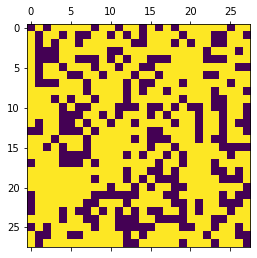

In [7]:
with torch.no_grad():
    z = torch.randn(64, 2).to(device)
    sample = vae.decode(z)
    sample = torch.reshape(sample, (64, 28, 28))
plt.matshow(sample.cpu().numpy()[0])